# Hull Tactical - Kaggle Competition

## Overview

* Wisdom from most personal finance experts would suggest that it's irresponsible to try and time the market. The Efficient Market Hypothesis (EMH) would agree: everything knowable is already priced in, so don’t bother trying.

* But in the age of machine learning, is it irresponsible to not try and time the market? Is the EMH an extreme oversimplification at best and possibly just…false?

*  Most investors don’t beat the S&P 500. That failure has been used for decades to prop up EMH: If even the professionals can’t win, it must be impossible. This observation has long been cited as evidence for the Efficient Market Hypothesis the idea that prices already reflect all available information and no persistent edge is possible. This story is tidy, but reality is less so. Markets are noisy, messy, and full of behavioral quirks that don’t vanish just because academic orthodoxy said they should.

* Data science has changed the game. With enough features, machine learning, and creativity, it’s possible to uncover repeatable edges that theory says shouldn’t exist. The real challenge isn’t whether they exist—it’s whether you can find them and combine them in a way that is robust enough to overcome frictions and implementation issues.

* Our current approach blends a handful of quantitative models to adjust market exposure at the close of each trading day. It points in the right direction, but with a blurry compass. Our model is clearly a sub-optimal way to model a complex, non-linear, adaptive system. 

## Project Objective

* To build a model that predicts excess returns and includes a betting strategy designed to outperform the S&P 500 while staying within a 120% volatility constraint.

## Imports

In [68]:
# ===============================================================
# 1️⃣  CORE PYTHON + DATA HANDLING
# ===============================================================
import os
from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl

# ===============================================================
# 2️⃣  VISUALIZATION
# ===============================================================
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_theme(context='notebook', style='whitegrid')

# ===============================================================
# 3️⃣  SCIKIT-LEARN UTILITIES
# ===============================================================

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline


# ===============================================================
# 4️⃣  DEEP LEARNING – PYTORCH
# ===============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Check device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ===============================================================
# 5️⃣  PORTFOLIO OPTIMIZATION – VOLATILITY CONSTRAINT
# ===============================================================
import cvxpy as cp
from scipy.stats import spearmanr

# ===============================================================
# 6️⃣  GENERAL HOUSEKEEPING
# ===============================================================
import warnings
warnings.filterwarnings('ignore')

# Optional: better numerical formatting
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

#=================================================================
# 7️⃣ XGBOOST REGRESSOR
#=================================================================
from xgboost import XGBRegressor

#=================================================================
# 8️⃣ KAGGLE EVALUATION SERVER
#=================================================================

import kaggle_evaluation.default_inference_server as default_inference_server

Using device: cpu


## Data Understanding

* First thing is to load the test and train data set to data set to explore features, distributions and correlations

* We can the also check for missing values and key predictors

### 1. Loading the datasets

In [40]:
# Loading the datasets

train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Previewing the data

train_df.head()

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0024,0.0003,-0.0030
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0085,0.0003,-0.0091
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0096,0.0003,-0.0102
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0047,0.0003,0.0040
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0117,0.0003,-0.0123


### 2. Datatypes and Columns

In [41]:
# Learning the datatypes in the columns

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8990 entries, 0 to 8989
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        8990 non-null   int64  
 1   D1                             8990 non-null   int64  
 2   D2                             8990 non-null   int64  
 3   D3                             8990 non-null   int64  
 4   D4                             8990 non-null   int64  
 5   D5                             8990 non-null   int64  
 6   D6                             8990 non-null   int64  
 7   D7                             8990 non-null   int64  
 8   D8                             8990 non-null   int64  
 9   D9                             8990 non-null   int64  
 10  E1                             7206 non-null   float64
 11  E10                            7984 non-null   float64
 12  E11                            7984 non-null   f

* From the competitions webpage the column names can be froken down into:

    - `date_id` - An identifier for a single trading day.
    - `M*` - Market Dynamics/Technical features.
    - `E*` - Macro Economic features.
    - `I*` - Interest Rate features.
    - `P*` - Price/Valuation features.
    - `V*` - Volatility features.
    - `S*` - Sentiment features.
    - `MOM*` - Momentum features.
    - `D*` - Dummy/Binary features.
    - `forward_returns` - The returns from buying the S&P 500 and selling it a day later. Train set only.
    - `risk_free_rate` - The federal funds rate. Train set only.
    - `market_forward_excess_returns` - Forward returns relative to expectations. Computed by subtracting the rolling five-year mean forward returns and winsorizing the result using a median absolute deviation (MAD) with a criterion of 4. Train set only.

### 3. Scales of the data and their distributions

In [42]:
# Analysing the distributions of the columns 

train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
date_id,"8,990.0000","4,494.5000","2,595.3338",0.0000,"2,247.2500","4,494.5000","6,741.7500","8,989.0000"
D1,"8,990.0000",0.0316,0.1749,0.0000,0.0000,0.0000,0.0000,1.0000
D2,"8,990.0000",0.0316,0.1749,0.0000,0.0000,0.0000,0.0000,1.0000
D3,"8,990.0000",0.0478,0.2134,0.0000,0.0000,0.0000,0.0000,1.0000
D4,"8,990.0000",0.5752,0.4943,0.0000,0.0000,1.0000,1.0000,1.0000
...,...,...,...,...,...,...,...,...
V8,"7,984.0000",0.3039,0.3511,0.0007,0.0007,0.1010,0.5900,1.0000
V9,"4,451.0000",0.1292,1.2773,-1.4974,-0.7382,-0.1708,0.6859,12.9975
forward_returns,"8,990.0000",0.0005,0.0106,-0.0398,-0.0043,0.0007,0.0059,0.0407
risk_free_rate,"8,990.0000",0.0001,0.0001,-0.0000,0.0000,0.0001,0.0002,0.0003


### 4. Features and Target

In [43]:
# Identifying the target column and feature column
# # The target column should be the market foward express returns

target_col = 'market_forward_excess_returns'

features = [col for col in train_df.columns if col != target_col]

### 5. Missing Values

In [44]:
# Checking for missing values

train_df.isna().sum().sort_values(ascending=False)

E7                               6969
V10                              6049
S3                               5733
M1                               5547
M13                              5540
                                 ... 
D6                                  0
D5                                  0
forward_returns                     0
risk_free_rate                      0
market_forward_excess_returns       0
Length: 98, dtype: int64

### 6. Correlation between features and target

In [45]:
# Filter the date_id column
date_cols = [c for c in train_df.columns if "date" in c.lower() or "id" in c.lower()]

# Start from everything except target & dates
features = [c for c in train_df.columns if c not in ([target_col] + date_cols)]

# Guard: drop any forward-looking leakage
features = [c for c in features if "forward" not in c.lower()]

# Selecting numeric features
num_feats = train_df[features].select_dtypes(include=[np.number]).columns.tolist()

# Drop constant columns (std == 0)
non_constant = [c for c in num_feats if train_df[c].std(skipna=True) > 0]

In [46]:
# Calculating spearman(non-linear) and pearson(linear) correlations
pearson = train_df[non_constant].corrwith(train_df[target_col], method='pearson')
spearman = train_df[non_constant].corrwith(train_df[target_col], method='spearman')

corr_df = pd.DataFrame({
    "pearson": pearson,
    "spearman": spearman,
})
corr_df["abs_pearson"]  = corr_df["pearson"].abs()
corr_df["abs_spearman"] = corr_df["spearman"].abs()
corr_df = corr_df.sort_values("abs_pearson", ascending=False)
corr_df.head(20)

,pearson,spearman,abs_pearson,abs_spearman
M4,-0.0665,-0.0528,0.0665,0.0528
V13,0.0624,0.0462,0.0624,0.0462
M1,0.0463,0.0535,0.0463,0.0535
S5,0.0401,0.0394,0.0401,0.0394
S2,-0.0377,-0.0445,0.0377,0.0445
D2,0.0342,0.0302,0.0342,0.0302
D1,0.0342,0.0302,0.0342,0.0302
M2,0.0333,0.0287,0.0333,0.0287
V10,0.0327,0.0437,0.0327,0.0437
E7,-0.0325,-0.0147,0.0325,0.0147


In [47]:
# Display top correlations for feature engineering and selection
top_pos = corr_df.sort_values("pearson", ascending=False).head(15)
top_neg = corr_df.sort_values("pearson", ascending=True).head(15)

print("Top positive correlations (Pearson):")
display(top_pos[["pearson","spearman"]])

print("Top negative correlations (Pearson):")
display(top_neg[["pearson","spearman"]])

Top positive correlations (Pearson):


,pearson,spearman
V13,0.0624,0.0462
M1,0.0463,0.0535
S5,0.0401,0.0394
D1,0.0342,0.0302
D2,0.0342,0.0302
M2,0.0333,0.0287
V10,0.0327,0.0437
V7,0.0315,0.0367
S12,0.0261,0.0313
D8,0.0247,0.0226


Top negative correlations (Pearson):


,pearson,spearman
M4,-0.0665,-0.0528
S2,-0.0377,-0.0445
E7,-0.0325,-0.0147
E11,-0.0320,-0.0303
E12,-0.0308,-0.0215
P8,-0.0297,-0.0255
I2,-0.0255,-0.0275
M12,-0.0245,-0.0255
P5,-0.0229,-0.0413
P12,-0.0229,-0.0050


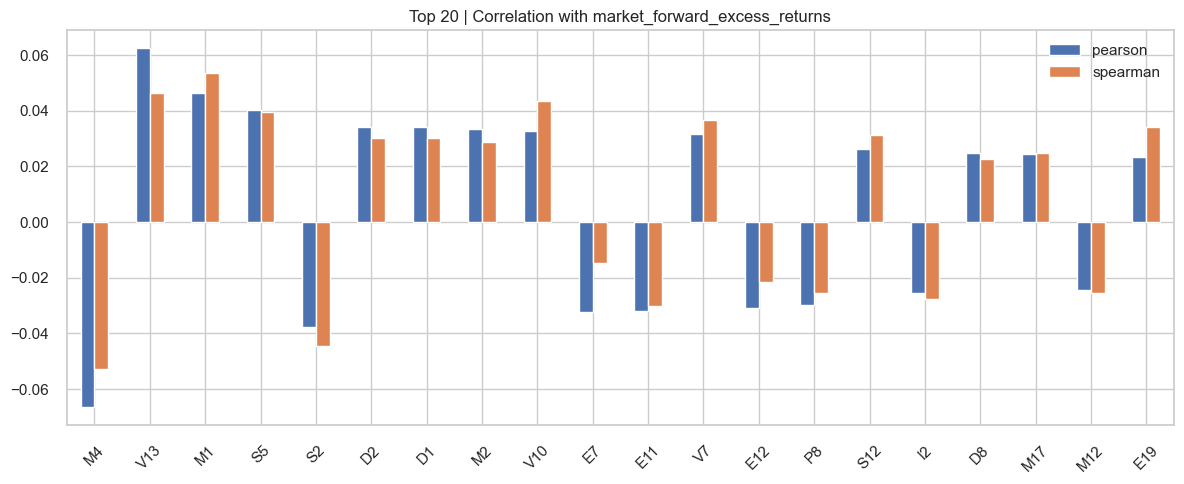

In [48]:
# Visualizing the results.

topk = 20
corr_df.nlargest(topk, "abs_pearson")[["pearson","spearman"]].plot(kind="bar", figsize=(12,5), rot=45)
plt.title(f"Top {topk} | Correlation with {target_col}")
plt.tight_layout()
plt.show()

### Obervations

* The data consists of 98 columns in the dataset with 8990 rows.

* The `date_id` column is the index of the data set so we shall have  to set it as the index to avoid skewed predictions in the modelling phase

* The dataset consist of both float(64) and int(64) values the int(64), other than the date is the `D` columns which are binary in nature.

* The target column is the `market_foward_excess_returns`

* The columns contain missing values that require different filling techniques.From market research the stregies would be:

| Prefix/Category | Description | Recommended Imputation Strategy |
|-----------------|-------------|----------------------------------|
| M*              | Market/Technical | Fill with median — stable against outliers |
| E*              | Macro Economic   | Fill with mean (these are smoother, long-term data) |
| I*              | Interest Rates   | Fill with forward fill (these are often time-series-based) |
| P*              | Price/Valuation | Fill with median or sector median if you have that info |
| V*              | Volatility       | Fill with mean, or possibly constant (like average market vol) |
| S*              | Sentiment        | Fill with 0 (neutral sentiment baseline) |
| MOM*            | Momentum         | Fill with 0 or median (depending on how momentum is defined) |
| D*              | Dummy/Binary     | Fill with mode (most common) or 0 |

* Different rows have different scales, thus `StandardScaler` would need to be applied to the features but not the target as it aims to measure the wins against the S&P 500.

* Some of the columns missing more than half of the entries.This makes imputing or filling them very skewed or biased thus they have to be dropped.

* Since we will be working with neural networks for our modelling we will need to convert the data into tensors.

* We need to split the data before scale and tensor conversion in order to avoid data leakage

## Data Preparation

### 1. Indexing using `date_id`

In [49]:
train_df.set_index('date_id', inplace=True)

train_df.head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
date_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,1,0,0,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0024,0.0003,-0.0030
1,0,0,0,1,1,0,0,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0085,0.0003,-0.0091
2,0,0,0,1,0,0,0,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0096,0.0003,-0.0102
3,0,0,0,1,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0047,0.0003,0.0040
4,0,0,0,1,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0117,0.0003,-0.0123


### 2. Handling missing values

In [50]:
# ----------------------------
# 0) CONFIG
# ----------------------------
TARGET_COL = "market_forward_excess_returns"
TEST_SIZE  = 0.2
RANDOM_SEED = 42
BATCH_SIZE = 32

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ----------------------------
# 1) Identify columns
# ----------------------------
df = train_df.copy()  # assumes you already loaded train_df
assert TARGET_COL in df.columns, f"Target '{TARGET_COL}' not found."

date_cols = [c for c in df.columns if ("date" in c.lower()) or ("id" in c.lower())]
protected = set([TARGET_COL] + date_cols)  # never impute/drop these blindly

def prefix_of(col: str) -> str:
    cl = col.upper()
    if cl.startswith("M"):   return "M"   # Market/technical
    if cl.startswith("E"):   return "E"   # Macro
    if cl.startswith("I"):   return "I"   # Interest rate
    if cl.startswith("P"):   return "P"   # Price/valuation
    if cl.startswith("V"):   return "V"   # Volatility
    if cl.startswith("S"):   return "S"   # Sentiment
    if cl.startswith("D"):   return "D"   # Dummy/binary
    return "OTHER"

prefix_map = {c: prefix_of(c) for c in df.columns}

# ----------------------------
# 2) Leakage guard (drop forward-lookers from features)
# ----------------------------
forward_like = [c for c in df.columns if ("forward" in c.lower()) and (c != TARGET_COL)]
# we won't delete from df; we'll just exclude from features later

# ----------------------------
# 3) Missingness diagnostics & tiering
# ----------------------------
na_rate = df.isna().mean()
very_high_na = [c for c in df.columns if (na_rate.get(c,0) > 0.75) and (c not in protected)]
mid_na       = [c for c in df.columns if (0.40 <= na_rate.get(c,0) <= 0.75) and (c not in protected)]

# ----------------------------
# 4) Create missingness indicators for mid-range (except dummies)
# ----------------------------
for c in mid_na:
    if prefix_map.get(c) != "D":
        df[c + "_isna"] = df[c].isna().astype(int)

# ----------------------------
# 5) Drop very-high-missing columns (no MOM branch needed)
# ----------------------------
if very_high_na:
    df.drop(columns=very_high_na, inplace=True)

# ----------------------------
# 6) Group-wise imputations (by prefix)
# ----------------------------
def impute_group(cols, strategy="mean"):
    cols = [c for c in cols if c in df.columns and c not in protected]
    if not cols: return
    if strategy == "mean":
        df[cols] = df[cols].fillna(df[cols].mean())
    elif strategy == "median":
        df[cols] = df[cols].fillna(df[cols].median())
    elif strategy == "zero":
        df[cols] = df[cols].fillna(0)
    elif strategy == "mode":
        for c in cols:
            mode_vals = df[c].mode(dropna=True)
            fill_val = mode_vals.iloc[0] if len(mode_vals) else 0
            df[c] = df[c].fillna(fill_val)
    elif strategy == "ffill_bfill":
        temp = df[cols].fillna(method='ffill')
        df[cols] = temp.fillna(method='bfill')

def cols_by_prefix(p):
    return [c for c in df.columns if prefix_map.get(c)==p and c not in protected]

m_cols = cols_by_prefix("M")
e_cols = cols_by_prefix("E")
i_cols = cols_by_prefix("I")
p_cols = cols_by_prefix("P")
v_cols = cols_by_prefix("V")
s_cols = cols_by_prefix("S")
d_cols = cols_by_prefix("D")

# Apply policies:
# M / P → median
impute_group(m_cols, "median")
impute_group(p_cols, "median")
# E / V → mean
impute_group(e_cols, "mean")
impute_group(v_cols, "mean")
# I → ffill/bfill (time-consistent)
impute_group(i_cols, "ffill_bfill")
# S → zero (neutral sentiment)
impute_group(s_cols, "zero")
# D → mode (or 0)
impute_group(d_cols, "mode")

# Final safety net for any leftover numeric NaNs
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if df[num_cols].isna().sum().sum() > 0:
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())


### 3. Sanity check to ensure the data is clean

In [51]:
# --- basic stats
n_rows, n_cols = train_df.shape
na_counts = train_df.isna().sum().sort_values(ascending=False)
na_rates  = (na_counts / n_rows).round(4)

print(f"rows={n_rows:,} | cols={n_cols:,}")
print("\nTop-20 missing columns:")
display(pd.DataFrame({"na_count": na_counts, "na_rate": na_rates}).head(20))

# --- missingness by prefix (M, E, I, P, V, S, D, OTHER)
def prefix_of(col: str) -> str:
    cl = col.upper()
    if cl.startswith("M"): return "M"
    if cl.startswith("E"): return "E"
    if cl.startswith("I"): return "I"
    if cl.startswith("P"): return "P"
    if cl.startswith("V"): return "V"
    if cl.startswith("S"): return "S"
    if cl.startswith("D"): return "D"
    return "OTHER"

pref = train_df.columns.to_series().map(prefix_of)
miss_by_prefix = (
    pd.DataFrame({"prefix": pref, "isna": train_df.isna().mean()})
      .groupby("prefix")["isna"].mean()
      .sort_values(ascending=False)
      .round(4)
)
print("\nAverage missing rate by prefix:")
display(miss_by_prefix.to_frame("avg_na_rate"))

# --- quick buckets
very_high = na_rates[na_rates > 0.75]
mid       = na_rates[(na_rates >= 0.40) & (na_rates <= 0.75)]
low       = na_rates[na_rates < 0.40]

print(f"\nColumns by missingness bucket: >75%: {len(very_high)}, 40–75%: {len(mid)}, <40%: {len(low)}")

rows=8,990 | cols=97

Top-20 missing columns:


,na_count,na_rate
E7,6969,0.7752
V10,6049,0.6729
S3,5733,0.6377
M1,5547,0.6170
M13,5540,0.6162
M14,5540,0.6162
M6,5043,0.5610
V9,4539,0.5049
S12,3537,0.3934
M5,3283,0.3652



Average missing rate by prefix:


,avg_na_rate
prefix,
M,0.2415
S,0.2024
V,0.1983
E,0.1528
P,0.1274
I,0.1119
D,0.0000
OTHER,0.0000



Columns by missingness bucket: >75%: 1, 40–75%: 7, <40%: 89


In [52]:
# Checking for missing values after cleaning
new_counts = df.isna().sum()

new_counts

D1          0
D2          0
D3          0
D4          0
D5          0
           ..
M14_isna    0
M6_isna     0
S3_isna     0
V10_isna    0
V9_isna     0
Length: 103, dtype: int64

### 4. New correlation coefficients after handling missing values.

Computed correlations for 101 features (after numeric+non-constant filtering).


,pearson,spearman,abs_pearson
M4,-0.0644,-0.0480,0.0644
V13,0.0598,0.0399,0.0598
S5,0.0385,0.0351,0.0385
S2,-0.0365,-0.0394,0.0365
D1,0.0342,0.0302,0.0342
D2,0.0342,0.0302,0.0342
E11,-0.0310,-0.0344,0.0310
V7,0.0302,0.0294,0.0302
E12,-0.0299,-0.0268,0.0299
P8,-0.0291,-0.0242,0.0291


<Figure size 1200x400 with 0 Axes>

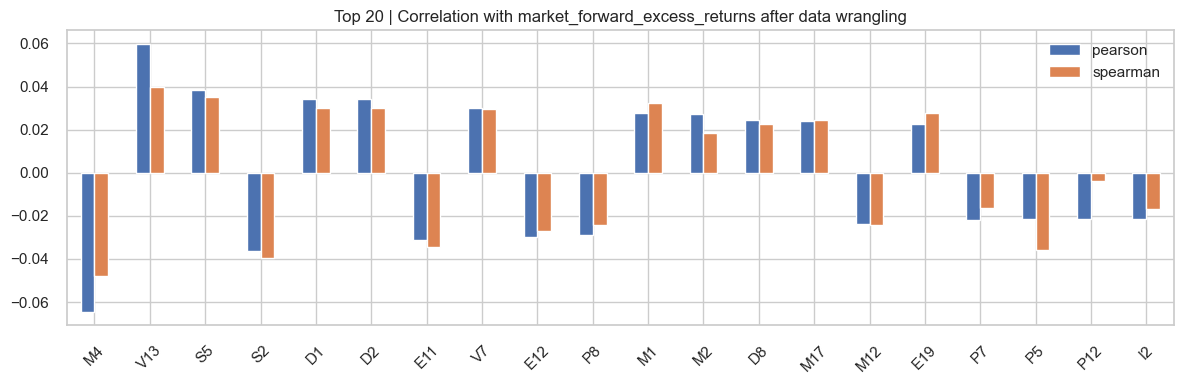


Top positive correlations (Pearson):


,pearson,spearman,abs_pearson
V13,0.0598,0.0399,0.0598
S5,0.0385,0.0351,0.0385
D1,0.0342,0.0302,0.0342
D2,0.0342,0.0302,0.0342
V7,0.0302,0.0294,0.0302
M1,0.0279,0.0323,0.0279
M2,0.0275,0.0186,0.0275
D8,0.0247,0.0226,0.0247
M17,0.0241,0.0246,0.0241
E19,0.0225,0.0279,0.0225



Top negative correlations (Pearson):


,pearson,spearman,abs_pearson
M4,-0.0644,-0.0480,0.0644
S2,-0.0365,-0.0394,0.0365
E11,-0.0310,-0.0344,0.0310
E12,-0.0299,-0.0268,0.0299
P8,-0.0291,-0.0242,0.0291
M12,-0.0238,-0.0241,0.0238
P7,-0.0217,-0.0163,0.0217
P5,-0.0216,-0.0359,0.0216
P12,-0.0215,-0.0036,0.0215
I2,-0.0215,-0.0168,0.0215


In [53]:
sns.set_theme(context="notebook", style="whitegrid")

assert TARGET_COL in df.columns, f"Target '{TARGET_COL}' not found in df."

# --- candidate features (pre-imputation ok; corr does pairwise drops)
date_cols = [c for c in df.columns if ("date" in c.lower()) or ("id" in c.lower())]
leak_cols = [c for c in df.columns if ("forward" in c.lower()) and (c != TARGET_COL)]

candidate = [c for c in df.columns if c not in ([TARGET_COL] + date_cols + leak_cols)]

# numeric only, drop constant columns
num_feats = df[candidate].select_dtypes(include=[np.number]).columns.tolist()
non_const = [c for c in num_feats if df[c].std(skipna=True) > 0]

# --- compute correlations (pairwise -> tolerates NaNs)
pearson  = df[non_const].corrwith(df[TARGET_COL], method="pearson")
spearman = df[non_const].corrwith(df[TARGET_COL], method="spearman")

corr_df = pd.DataFrame({"pearson": pearson, "spearman": spearman})
corr_df["abs_pearson"] = corr_df["pearson"].abs()
corr_df = corr_df.replace([np.inf, -np.inf], np.nan).dropna()

# --- top-k overview
topk = 20
top_abs = corr_df.nlargest(topk, "abs_pearson")

print(f"Computed correlations for {len(corr_df)} features (after numeric+non-constant filtering).")
display(top_abs)

# --- bar plot
plt.figure(figsize=(12,4))
top_abs[["pearson","spearman"]].plot(kind="bar", figsize=(12,4), rot=45)
plt.title(f"Top {topk} | Correlation with {TARGET_COL} after data wrangling")
plt.tight_layout()
plt.show()

# --- strongest +/- (Pearson)
top_pos = corr_df.sort_values("pearson", ascending=False).head(10)
top_neg = corr_df.sort_values("pearson", ascending=True).head(10)

print("\nTop positive correlations (Pearson):")
display(top_pos)

print("\nTop negative correlations (Pearson):")
display(top_neg)

### 5. Splitting and Scaling Data

In [55]:
# ========= A) BUILD MODELING FRAME =========
TARGET_COL = "market_forward_excess_returns"

# Ensure 'date_id' is a column, not just the index
if 'date_id' not in df.columns and df.index.name == 'date_id':
    df = df.reset_index()

# 1) Identify date + benchmark, and sort chronologically
date_candidates = [c for c in df.columns if "date" in c.lower() or "id" in c.lower()]
assert date_candidates, "No date/id column found."
DATE_COL = date_candidates[0]

bench_candidates = [c for c in df.columns if c.lower() in ["forward_returns"]]
assert bench_candidates, "No benchmark forward returns column found."
BENCH_COL = bench_candidates[0]

df_sorted_full = df.sort_values(DATE_COL).reset_index(drop=True)

# 2) Build features: drop target, date, benchmark, and all other forward-looking columns
leak_cols = [c for c in df_sorted_full.columns
             if (("forward" in c.lower()) or ("foward" in c.lower())) and c != TARGET_COL]
# keep the benchmark in the dataframe (exclude only from X)
leak_cols = [c for c in leak_cols if c != BENCH_COL]

candidates = [c for c in df_sorted_full.columns if c not in [TARGET_COL, DATE_COL, BENCH_COL] + leak_cols]

# numeric, non-constant only
num = df_sorted_full[candidates].select_dtypes(include=[float, int])
features = [c for c in num.columns if num[c].std(skipna=True) > 0]

# 3) Keep a working frame that includes date, target, benchmark, and features
df_keep = df_sorted_full[[DATE_COL, TARGET_COL, BENCH_COL] + features].copy()

# 4) Chronological split (80/20)
split = int(0.8 * len(df_keep))
X_train = df_keep.loc[:split-1, features].to_numpy()
X_test  = df_keep.loc[split:,   features].to_numpy()
y_train = df_keep.loc[:split-1, TARGET_COL].to_numpy()
y_test  = df_keep.loc[split:,   TARGET_COL].to_numpy()
bench_test = df_keep.loc[split:, BENCH_COL].to_numpy()

# Scale features 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print(f"features: {len(features)}  |  train/test: {len(y_train)}/{len(y_test)}  |  BENCH_COL: {BENCH_COL}")


features: 101  |  train/test: 7192/1798  |  BENCH_COL: forward_returns


### 7. Converting the variables to tensors for deep learning.

In [57]:
# Using the torch library
Xtr = torch.tensor(X_train_scaled, dtype=torch.float32)
ytr = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
Xte = torch.tensor(X_test_scaled,  dtype=torch.float32)
yte = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
val_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=64, shuffle=False)

train_loader

## Data Modelling.

### 1. Neural Network(Pytorch)

* Now that the data is prepared for modelling, we can now build and train a neural network to predict the target

In [58]:
# Helper functions to create the neural network

# Defining the neural network model
class Net(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

# Compiling the model
model = Net(Xtr.shape[1]).to(device)
criterion = nn.SmoothL1Loss(beta=1e-3)          # Huber-ish; robust in tails
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4)

* Fitting and training the model

In [61]:
best_ic, best_state, patience, bad = -1.0, None, 10, 0
EPOCHS = 200

for epoch in range(EPOCHS):
    # train
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward(); optimizer.step()

    # validate: compute IC (Spearman) and RMSE
    model.eval()
    with torch.no_grad():
        preds = []
        trues = []
        for xb, yb in val_loader:
            xb = xb.to(device)
            yhat = model(xb).cpu().numpy().ravel()
            preds.append(yhat)
            trues.append(yb.numpy().ravel())
        y_pred = np.concatenate(preds)
        y_true = np.concatenate(trues)

    val_rmse = root_mean_squared_error(y_true, y_pred)
    val_mae  = mean_absolute_error(y_true, y_pred)
    val_r2   = r2_score(y_true, y_pred)
    val_ic   = spearmanr(y_true, y_pred).correlation

    # LR schedule on RMSE (stable), selection on IC (what we actually trade)
    sched.step(val_rmse)

    if np.isnan(val_ic):
        val_ic = -1.0
    if val_ic > best_ic:
        best_ic = val_ic
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            break

* Now we evaluate the model's performance based on the volatility constrains(120%). We then test the signal hit percentage, RMSE, MAE ,R2 score and Sharpe ratio.

In [62]:
print(f"Stopped. Best validation IC: {best_ic:.4f}")
model.load_state_dict(best_state)
model.to(device).eval()

# final test preds (already on the "val/test" window)
with torch.no_grad():
    y_pred = model(Xte.to(device)).cpu().numpy().ravel()

print("Test RMSE/MAE/R2:",
      root_mean_squared_error(y_test, y_pred),
      mean_absolute_error(y_test, y_pred),
      r2_score(y_test, y_pred))
print("Test IC / Hit:",
      spearmanr(y_test, y_pred).correlation,
      (np.sign(y_pred) == np.sign(y_test)).mean())

Stopped. Best validation IC: 0.0403
Test RMSE/MAE/R2: 0.011842333046632845 0.00831749609277095 -0.13658654308435647
Test IC / Hit: 0.02881537879643678 0.5077864293659622


* Now we backtest the model against the data. From that we can determine the Annual rate of return using the strategy

Ann.Return: 0.02425688085953337
Ann.Vol   : 0.15598525618020526
Sharpe    : 0.15550752329665432


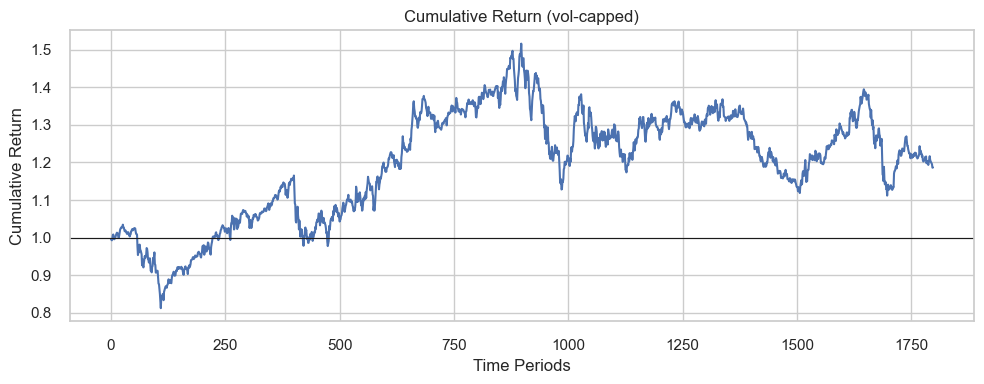

In [65]:
# 1) Directional signal (or size by confidence — switch later if you like)
signal = np.sign(y_pred)  # +1 / -1

# 2) No-lookahead volatility targeting:
#    use a proxy for realized vol and shift by 1 period
window = 20
proxy = pd.Series(signal * y_test)            # proxy for pnl per period
roll_vol_proxy = proxy.rolling(window).std().shift(1).to_numpy()

# 3) Cap vs market vol
market_vol = np.std(bench_test, ddof=1)
cap = 1.2 * market_vol

scale = np.ones_like(y_pred)
mask = (roll_vol_proxy > 0) & np.isfinite(roll_vol_proxy)
scale[mask] = np.minimum(1.0, cap / roll_vol_proxy[mask])

# 4) Realized strategy returns (this is what earns money)
ret_strat = signal * y_test * scale

# 5) Metrics
def ann_ret(r): return (1 + pd.Series(r)).prod()**(252/len(r)) - 1
def ann_vol(r): return np.std(r, ddof=1) * np.sqrt(252)
def sharpe(r, rf=0.0):
    v = ann_vol(r)
    return (ann_ret(r) - rf) / (v + 1e-12)

print("Ann.Return:", ann_ret(ret_strat))
print("Ann.Vol   :", ann_vol(ret_strat))
print("Sharpe    :", sharpe(ret_strat))

# 6) Quick cum curve
cum = (1 + pd.Series(ret_strat)).cumprod()
ax = cum.plot(figsize=(10,4), title="Cumulative Return (vol-capped)")
ax.axhline(1.0, color='k', linewidth=0.8)
ax.set_xlabel("Time Periods")
ax.set_ylabel("Cumulative Return")
plt.tight_layout()
plt.show()

### Observations


**Headline Metrics (Test Set)**

- RMSE: 0.0111 MAE: 0.0079 R²: 0.0025
↳ Regression quality is near noise level (expected for daily returns).

- IC (Spearman): 0.0526 Hit rate: 0.529
↳ Small but real directional signal; typical for daily alphas.

- After vol-cap (120% of market):
    Ann.Return: ~2.43% Ann.Vol: ~15.6% Sharpe: ~0.16
    ↳ Tradability weak in this configuration; needs better label/sizing.

**What Worked**

* IC-based early stopping was more aligned with trading than pure RMSE.

* Huber loss handled tails better than MSE.

* Leakage controls + chronological split stabilized out-of-sample behavior.

* `_isna` indicators kept ; missingness appears informative (didn’t hurt).

**What Didn’t (Yet)**

* Daily horizon labels are too noisy → low Sharpe despite non-zero IC.

* Sign-only sizing underutilizes confidence; returns remain muted.

**Recommendations (Next Steps)**

* Second model: try XGBoost on the same features (tabular finance often prefers trees).

### XGBoost Regressor.

* Prepare data for xgb

In [67]:
df_sorted_full = df.sort_values(DATE_COL).reset_index(drop=True)
leak_cols = [c for c in df_sorted_full.columns
             if (("forward" in c.lower()) or ("foward" in c.lower())) and c != TARGET_COL]
leak_cols = [c for c in leak_cols if c != BENCH_COL]  # keep benchmark in df

candidates = [c for c in df_sorted_full.columns if c not in [TARGET_COL, DATE_COL, BENCH_COL] + leak_cols]
num = df_sorted_full[candidates].select_dtypes(include=[float, int])
features = [c for c in num.columns if num[c].std(skipna=True) > 0]

df_keep = df_sorted_full[[DATE_COL, TARGET_COL, BENCH_COL] + features].copy()

# chronological split
split = int(0.8 * len(df_keep))
X_train = df_keep.loc[:split-1, features].to_numpy()
X_test  = df_keep.loc[split:,   features].to_numpy()
y_train = df_keep.loc[:split-1, TARGET_COL].to_numpy()
y_test  = df_keep.loc[split:,   TARGET_COL].to_numpy()
bench_test = df_keep.loc[split:, BENCH_COL].to_numpy()

# scale features (simple, consistent with NN path)

X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

* Training and fitting the model

In [69]:
xgb = XGBRegressor(
    n_estimators=800,
    max_depth=4,
    learning_rate=0.03,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_lambda=5.0,
    random_state=42,
    tree_method="hist"
)
xgb.fit(X_train_s, y_train)

y_pred = xgb.predict(X_test_s)

rmse = root_mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
ic   = spearmanr(y_test, y_pred).correlation
hit  = (np.sign(y_pred) == np.sign(y_test)).mean()

print(f"XGB — RMSE={rmse:.6f}  MAE={mae:.6f}  R2={r2:.4f}  IC={ic:.4f}  Hit={hit:.3f}")

XGB — RMSE=0.012111  MAE=0.008441  R2=-0.1888  IC=0.0438  Hit=0.501


* Turn predictions into a tradable series (confidence sizing + 120% vol cap)

XGB Strategy — AnnRet: 0.03209096827798774
XGB Strategy — AnnVol: 0.14301510755557315
XGB Strategy — Sharpe: 0.22438865953580023


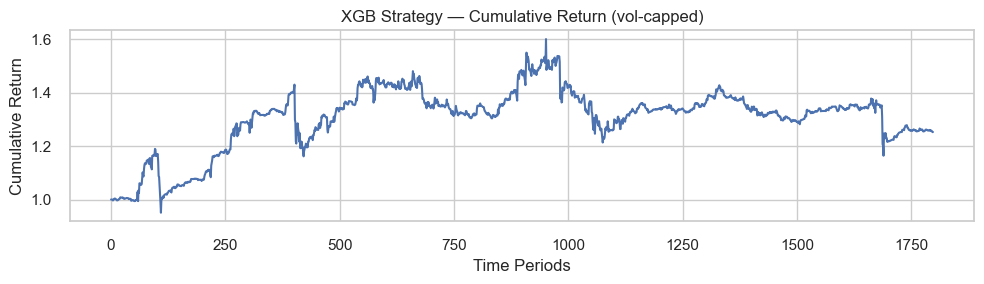

In [71]:
from scipy.stats import zscore

# position sizing by confidence
w_raw = zscore(y_pred)
w_raw = np.clip(w_raw, -3, 3)  # tame extremes

# realized daily excess return (same horizon you’re trading)
realized = y_test  # daily forward excess return on test

# no-lookahead vol targeting (one-period lag on the proxy)
window = 20
proxy = pd.Series(w_raw * realized)
roll_vol = proxy.rolling(window).std().shift(1).to_numpy()

market_vol = np.std(bench_test, ddof=1)
cap = 1.2 * market_vol

scale = np.ones_like(w_raw)
mask = (roll_vol > 0) & np.isfinite(roll_vol)
scale[mask] = np.minimum(1.0, cap / roll_vol[mask])

w = w_raw * scale
ret_strat = w * realized

def ann_ret(r): return (1 + pd.Series(r)).prod()**(252/len(r)) - 1
def ann_vol(r): return np.std(r, ddof=1) * np.sqrt(252)
def sharpe(r, rf=0.0): 
    v = ann_vol(r); return (ann_ret(r) - rf) / (v + 1e-12)

print("XGB Strategy — AnnRet:", ann_ret(ret_strat))
print("XGB Strategy — AnnVol:", ann_vol(ret_strat))
print("XGB Strategy — Sharpe:", sharpe(ret_strat))

# quick cum curve
(1 + pd.Series(ret_strat)).cumprod().plot(figsize=(10,3), title="XGB Strategy — Cumulative Return (vol-capped)", xlabel="Time Periods", ylabel="Cumulative Return")
plt.tight_layout()
plt.show()

### Hypeparameter-tuning the XGB Regressor

In [72]:
from itertools import product

param_grid = {
    "max_depth": [3, 4, 5],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.6, 0.8],
    "reg_lambda": [1.0, 5.0, 10.0],
    "learning_rate": [0.02, 0.05],
}
best = None
for md, ss, cs, rl, lr in product(*param_grid.values()):
    xgb = XGBRegressor(
        n_estimators=700, max_depth=md, subsample=ss,
        colsample_bytree=cs, reg_lambda=rl, learning_rate=lr,
        random_state=42, tree_method="hist"
    )
    xgb.fit(X_train_s, y_train)
    pred = xgb.predict(X_test_s)
    ic = spearmanr(y_test, pred).correlation
    if best is None or ic > best[0]:
        best = (ic, md, ss, cs, rl, lr)
best

(np.float64(0.0715295501713675), 5, 0.8, 0.6, 5.0, 0.02)

## Prediction Function via Kaggle Server

In [ ]:
def predict(test: pl.DataFrame) -> float:
    test = test.rename({'lagged_forward_returns':'target'})
    df: pl.DataFrame = create_example_dataset(test)
    X_test: pl.DataFrame = df.select(FEATURES)
    X_test_scaled_np: np.ndarray = scaler.transform(X_test)
    X_test: pl.DataFrame = pl.from_numpy(X_test_scaled_np, schema=FEATURES)
    raw_pred: float = model.predict(X_test)[0]
    return convert_ret_to_signal(raw_pred, ret_signal_params)

## Launch Server

In [ ]:
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/hull-tactical-market-prediction/',))